# Calculate and glacier terminus positions at different dates
### Jukes Liu

Files used:
    - Terminus box coordinates and Path Row information (Boxes_coords_pathrows.csv)
    - Terminus chains picked by size (terminuspicks_size_2019_07_24.csv)
    - Terminus chains picked by mass (terminuspicks_mass_2019_07_24.csv)
    - DateTimes of satellite images (datetags.csv)

### Import packages and read in csv files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import datetime
import types
import os
import cv2

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [28]:
#Read in file with box coordinates
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in files with terminus picks
#size
# termini_df_s = pd.read_csv(basepath+'terminuspicks_size_2019_07_25.csv', sep=',', dtype=str, header=1)
# termini_df_s.replace(to_replace ="NaN", value = np.nan)
#mass
termini_df_m = pd.read_csv(basepath+'terminuspicks_mass_2019_08_15.csv', sep=',', dtype=str, usecols=[0,1], header=1)
termini_df_m.replace(to_replace ="NaN", value = np.nan)


#Check column names and number of rows for the termini_dfs:
print(termini_df_m.columns.values)
termini_df_rownum = termini_df_m.shape[0]
print(termini_df_rownum)

#look at the DataFrames
#box_df
termini_df_m.head()

['BoxID' 'Scene']
926


,BoxID,Scene
0,001,LC80350052016116LGN00
1,001,LC80310052014242LGN00
2,001,LC80310052016152LGN00
3,001,LC80310052014226LGN00
4,001,LC80340052016109LGN00


### Read in trimmed line centroids and datfile names and add in DataFrame

In [35]:
massorsize="mass"
centroids_df = pd.read_csv(basepath+'trim_centroids_'+massorsize+'.csv', sep=',', usecols =[1,2,3,4], dtype=str)
centroids_df.head(10)

,Scene,BoxID,Centroid_X,Centroid_Y
0,LC80130022017108LGN00,001,144.74074074074073,159.57407407407408
1,LC80100022015258LGN00,001,169.25925925925927,150.33333333333334
2,LC80120022014269LGN00,001,183.31428571428572,153.71428571428572
3,LC80100022013124LGN01,001,144.859649122807,158.80701754385964
4,LC80110022014182LGN00,001,144.1864406779661,157.3728813559322
5,LC80080022015116LGN00,001,132.75,164.0909090909091
6,LC80060032014083LGN00,001,153.20731707317074,160.5731707317073
7,LC80140012014171LGN00,001,132.425,163.9875
8,LC80120022017101LGN00,001,159.69014084507043,161.09859154929578
9,LC80070022015109LGN00,001,132.58620689655172,163.45977011494253


In [26]:
# #Read in the imagenames to add to DataFrame
# imagenames_df = pd.read_csv(basepath+'imagenames.csv', sep=',', dtype=str, usecols =[0,2,3], header=0)
# imagenames_df.head()

In [44]:
combined_df = termini_df_m.set_index('Scene').join(centroids_df.set_index('Scene'), lsuffix='_xsmurf', rsuffix='_centroids')
# combined_df = combined_df.join(imagenames_df.set_index('Scene'))
combined_df = combined_df.sort_values('BoxID_xsmurf', ascending=True)
combined_df

,BoxID_xsmurf,BoxID_centroids,Centroid_X,Centroid_Y
Scene,,,,
LC80310052014226LGN00,001,NaN,NaN,NaN
LC80350052015273LGN00,001,NaN,NaN,NaN
LC80350052016084LGN00,001,NaN,NaN,NaN
LC80350052016116LGN00,001,NaN,NaN,NaN
LC80350052016132LGN00,001,NaN,NaN,NaN
LC80350052016180LGN00,001,NaN,NaN,NaN
LC80350052016212LGN00,001,NaN,NaN,NaN
LC80350052016228LGN00,001,NaN,NaN,NaN
LC80350052016276LGN00,001,NaN,NaN,NaN


### Create DateTime objects for plotting timeseries

Option 1 - add in datetimes pulled from metadata files (datetags.csv)

In [10]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(basepath+'datetags.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])

#Turn datetimes into DateTime objects
#grab the datetime strings
datetimes = datetime_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
datetime_df['datetimes'] = datetime_objs
#datetime_df

#Merge the datetags into the termini_df dataframes:

termini_df_m = combined_df.join(datetime_df.set_index('Scene'))
# termini_df_s = pd.merge(termini_df_s, datetime_df, on='Scene', how='left')

In [11]:
termini_df_m.dtypes

BoxID                      object
Scale                      object
Posfirst                   object
Mass                       object
Centroid_X_orig            object
Centroid_Y_orig            object
Centroid_X_trim            object
Centroid_Y_trim            object
datetimes          datetime64[ns]
dtype: object

Option 2 - turn original date strings 'Img_Date' into DateTime objects

In [9]:
# #grab dates from DataFrames:
# dates_m = termini_df_m.loc[:, 'Img_Date']
# dates_s = termini_df_s.loc[:, 'Img_Date']

# #create list to hold new datetime objects
# datetime_objs_m = []
# datetime_objs_s = []

# #convert date string to DateTime
# for date in dates_m:
#     datetime_obj = datetime.datetime.strptime(date, '%Y%m%d')
#     datetime_objs_m.append(datetime_obj)
# for date in dates_s:
#     datetime_obj = datetime.datetime.strptime(date, '%Y%m%d')
#     datetime_objs_s.append(datetime_obj)

# #add as new column in dataframes called 'datetimes'
# termini_df_m['datetimes'] = datetime_objs_m
# termini_df_s['datetimes'] = datetime_objs_s

# #Check
# termini_df_s.head()

### Calculate distances from centroids to the box coordinates and the terminus change rates

In [12]:
#create lists of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs_m = []
# subset_dfs_s = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
    box_leftmost_x = np.float(box_df.loc[BoxID, 'leftmost_x'])
    box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
#     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)
    
    #subset the full DataFrames to just the Box of interest
    subset_df_m = termini_df_m[termini_df_m['BoxID'] == BoxID].copy()
#     subset_df_s = termini_df_s[termini_df_s['BoxID'] == BoxID].copy()
    
    #grab the centroids as an array
    centroids_x_m = np.array(subset_df_m.loc[:, 'Centroid_X_trim'])
    #convert to float
    centroids_x_m = centroids_x_m.astype(float)
    
#     centroids_x_s = np.array(subset_df_s.loc[:, 'Centroid_X_trim'])
#     #convert to float
#     centroids_x_s = centroids_x_s.astype(float)

    
    #CALCULATE THE X DISTANCE between each centroid and the leftmost point/midpoint of box
    xdist_leftmost_m = centroids_x_m - box_leftmost_x
    xdist_midpoint_m = centroids_x_m - box_midpoint_x
#     xdist_leftmost_s = centroids_x_s - box_leftmost_x
#     xdist_midpoint_s = centroids_x_s - box_midpoint_x

    #add these xdistances to the subset array
    subset_df_m['xdist_leftmost'] = xdist_leftmost_m*15
    subset_df_m['xdist_midpoint'] = xdist_midpoint_m*15
    
#     subset_df_s['xdist_leftmost'] = xdist_leftmost_s*15
#     subset_df_s['xdist_midpoint'] = xdist_midpoint_s*15
    
    
    #CALCULATE TERMINUS CHANGE RATE
    #sort the subset DataFrame by date of delineation from earliest to latest
    subset_df_m = subset_df_m.sort_values(by='datetimes', ascending=True)
#     subset_df_s = subset_df_s.sort_values(by='datetimes', ascending=True)
    
    #create lists to store terminus change rates
    changerates_m = []
#     changerates_s = []

    #For each entry in the subset of the overall DataFrame:
    for i in range(0, len(subset_df_m.index)):
        #print(i)
        #for the earliest entry, change rate is NaN
        if i == 0:
            #grab the date of the terminus position
            t_term_m = list(subset_df_m['datetimes'])[i]
            changerates_m.append(np.NaN)
#             t_term_s = list(subset_df_s['datetimes'])[i]
#             changerates_s.append(np.NaN)
            
        #for all other subsequententries
        if i > 0:
            #grab the date of the terminus position and the previous date
            t_term_m = list(subset_df_m['datetimes'])[i]
            t_term_prev_m = list(subset_df_m['datetimes'])[i-1]
#             t_term_s = list(subset_df_s['datetimes'])[i]
#             t_term_prev_s = list(subset_df_s['datetimes'])[i-1]

            #grab the terminus position and the previous terminus position
            x_term_m = list(subset_df_m['xdist_midpoint'])[i]
            x_term_prev_m = list(subset_df_m['xdist_midpoint'])[i-1]
            
#             x_term_s = list(subset_df_s['xdist_midpoint'])[i]
#             x_term_prev_s = list(subset_df_s['xdist_midpoint'])[i-1]
            
            #calculate the change in terminus position and the change in time
            deltax_m = x_term_m - x_term_prev_m
            deltat_m = t_term_m - t_term_prev_m
            
#             deltax_s = x_term_s - x_term_prev_s
#             deltat_s = t_term_s - t_term_prev_s
            
            #convert deltat object into raw days:
            deltat_m = deltat_m.days
#             deltat_s = deltat_s.days
#             print(BoxID, t_term, deltax, deltat)

            #calculate change rate in meters/day if deltat is not zero
            if deltat_m > 0:
                term_changerate_m = deltax_m/deltat_m
            else:
                #if the change in time is zero, enter 'repeat' as terminus change
                #two images from the same date were analyzed
                term_changerate_m = "repeat date"
                
#             if deltat_s > 0:
#                 term_changerate_s = deltax_s/deltat_s
#             else:
#                 term_changerate_s = "repeat date"

            #add the change rate to the change rate list
            changerates_m.append(term_changerate_m)
#             changerates_s.append(term_changerate_s)
              
    #print the terminus change rates (m/d)
#     for changerate in changerates_m:
#         print("{0:.2f}".format(changerate_m), "m/d")
    
    #add the terminus change rates to the subset df!
    subset_df_m['changerates(m/d)'] = changerates_m
#     subset_df_s['changerates(m/d)'] = changerates_s
    
    #append the subset dfs to the subset dfs listS
    subset_dfs_m.append(subset_df_m)
#     subset_dfs_s.append(subset_df_s)

#RECOMBINE THE SUBSET DFs
xdist_df_m = pd.concat(subset_dfs_m)
# xdist_df_s = pd.concat(subset_dfs_s)
xdist_df_m

,BoxID,Scale,Posfirst,Mass,Centroid_X_orig,Centroid_Y_orig,Centroid_X_trim,Centroid_Y_trim,datetimes,xdist_leftmost,xdist_midpoint,changerates(m/d)
LC80110022013115LGN01,531,000,95335,4301.8946954456,240.0,226.52272033691406,240.02325581395348,226.90697674418604,2013-04-25,1215.348837,1110.348837,NaN
LC80110022013147LGN00,531,015,114421,3278.2787689411,239.15126037597656,233.61344909667969,239.72413793103448,233.13793103448276,2013-05-27,1210.862069,1105.862069,-0.140212
LC80110022013243LGN00,531,032,132577,2708.4692070084,211.16346740722656,274.68267822265625,226.58620689655172,263.55172413793105,2013-08-31,1013.793103,908.793103,-2.0528
LC80110022013259LGN00,531,013,130822,4157.4747151095,233.24444580078125,245.57037353515625,234.1875,237.74107142857142,2013-09-16,1127.812500,1022.812500,7.12621
LC80060032013272LGN00,531,049,130374,1854.3484765440,235.09434509277344,242.42453002929688,235.0943396226415,242.4245283018868,2013-09-29,1141.415094,1036.415094,1.04635
LC80110022013275LGN00,531,017,113461,395.0215410129,190.92919921875,227.09735107421875,196.4805194805195,228.3896103896104,2013-10-02,562.207792,457.207792,-193.069
LC80060032014083LGN00,531,000,103064,2485.7864510600,241.90740966796875,227.25926208496094,241.90740740740742,227.25925925925927,2014-03-24,1243.611111,1138.611111,3.93875
LC80070032014106LGN00,531,020,128937,3072.2508851661,179.11679077148438,254.78102111816406,178.71304347826086,248.6086956521739,2014-04-16,295.695652,190.695652,-41.2137
LC80060032014147LGN00,531,001,96242,4310.8623940087,239.22579956054688,226.48387145996094,239.2439024390244,226.609756097561,2014-05-27,1203.658537,1098.658537,22.1454
LC80110022014150LGN00,531,000,95334,3545.8481500582,239.17164611816406,226.18656921386719,239.2153846153846,226.69230769230768,2014-05-30,1203.230769,1098.230769,-0.142589


### Plot terminus position and terminus change vs. datetime for each BoxID

In [13]:
#set dictionaries to call info in DataFrames for each individual BoxID
termini_bybox_m = {}
# termini_bybox_s = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df_m = xdist_df_m[xdist_df_m['BoxID'] == BoxID].copy()
#     termini_bybox_df_s = xdist_df_s[xdist_df_s['BoxID'] == BoxID].copy()
    #update to dictionaries
    termini_bybox_m.update( {BoxID: termini_bybox_df_m} )
#     termini_bybox_s.update( {BoxID: termini_bybox_df_s} )

Plot for each BoxID

In [45]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '001'
massorsize = "mass"
metric = "terminus_highest"+massorsize+"/"
downloadpath = '/media/jukes/jukes1/LS8aws/'
imagepath = downloadpath+"Box"+BOI+"/rotated/resized/"

#grab df for BOI 
df_BOI_m = termini_bybox_m[BOI]
#save it to csv file:
df_BOI_m.to_csv(path_or_buf = basepath+'terminuschange_Box'+BOI+'_'+massorsize+'.csv', sep=',')
# df_BOI_s = termini_bybox_s[BOI]

#drop any values that are NaNs or NaTs since they plot improperly
for index, row in df_BOI_m.iterrows():
#     print(index, row['xdist_midpoint'], row['changerates(m/d)'])
#     if (np.isnan(row['xdist_midpoint'])) or (row['changerates(m/d)'] == "repeat date"):
    #if the change rate is too positive, it's probably an incorrect pick
    if row['changerates(m/d)'] == "repeat date":
        df_BOI_m = df_BOI_m.drop(index, axis=0)
#     elif float(row['changerates(m/d)']) > 20.0:
#         df_BOI_m = df_BOI_m.drop(index, axis=0)
#         print("^ Row dropped")

# #PLOT EACH IMAGE AT A TIME
# for index, row in df_BOI_m.iterrows():
#     imagename = index
#     dat = row['Dat file name'] 
#     trimdat = row['Trimmed dat file name']
#     center_x = row['Centroid_X_trim']
#     center_y = row['Centroid_Y_trim']
#     print(center_x, center_y)
    
#     #Read in image as np array
#     image = mpimg.imread(imagepath+"crop_R_"+imagename+"_B8_PS_Buffer"+BOI+'.png')
    
#     datpath = imagepath+"crop_R_"+imagename+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    
#     #Read in dat file as np array and grab x and y values
#     #TRIMMED:
#     term_trim_dat = np.loadtxt(datpath+trimdat)
    
#     #ORIGINAL:
# #     term_dat = np.loadtxt(datpath+dat)
    
#         #TRIMMED
#     term_trim_xs = []
#     term_trim_ys = []

#     #grab x and y values for the terminus line
#     for j in term_trim_dat:
# #         print(j)
#         x, y = (j[0], j[1])
#         term_trim_xs.append(x)
#         term_trim_ys.append(y)
    
#     plt.figure(figsize=(20,10))
# #     #PLOT DATE IN TOP LEFT CORNER!
# #     plt.text(20, 25, date, fontsize=16, color='w')

#     imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
#     #plot trimmed line and centroid in red
#     plt.plot(term_trim_xs, term_trim_ys, c='red')
#     plt.plot(center_x, center_y, color='red', marker='x')

#     plt.axis("off")

# #     plt.savefig(basepath+"Box"+BOI+"/Results/term_"+massorsize+"_trim_"+imagename+".png", dpi=2000)
#     plt.show()
    


# # for index, row in df_BOI_s.iterrows():
# # #     print(index, row['xdist_midpoint'], row['changerates(m/d)'])
# # #     if (np.isnan(row['xdist_midpoint'])) or (row['changerates(m/d)'] == "repeat date"):
# #     if (row['changerates(m/d)'] > 20.0) or (row['changerates(m/d)'] == "repeat date"):
# #         df_BOI_s = df_BOI_s.drop(index, axis=0)
# # #         print("^ Row dropped")

# #set index to changerate for ease of plotting
# df_BOI_m = df_BOI_m.set_index('changerates(m/d)')
# # df_BOI_s = df_BOI_s.set_index('changerates(m/d)')


#PLOT TERMINUS POSITION 
# ax = df_BOI_m.plot(x='datetimes', y='xdist_midpoint', style='mo', figsize=(12,6))
ax = df_BOI_m.plot(x='datetimes', y='changerates(m/d)', style='bo-', figsize=(12,6))
# df_BOI_s.plot(x='datetimes', y='xdist_midpoint', style='co-', ax=ax)
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=16)
# plt.ylabel('Terminus position (m)', fontsize=18)
plt.ylabel('Terminus change rate (m/d)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
# plt.legend(labels=['Mass' ,'Size'])
plt.legend(labels=['Mass'])



# #LABEL EACH POINT BY TERMINUS CHANGE RATE
# for i, changerate_m in enumerate(df_BOI_m.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_m, float):
#         txt = str("{0:.2f}".format(changerate_m))
#         #If it's positive, add a + for clarity:
#         if changerate_m > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_m):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_m)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_m['datetimes'])[i] ,list(df_BOI_m['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,4), 
#                  textcoords='offset points',
#                  color='m')
# for i, changerate_s in enumerate(df_BOI_s.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_s, float):
#         txt = str("{0:.2f}".format(changerate_s))
#         #If it's positive, add a + for clarity:
#         if changerate_s > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_s):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_s)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_s['datetimes'])[i] ,list(df_BOI_s['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,-10), 
#                  textcoords='offset points',
#                  color='c')

#SAVE FIGURE
#plt.savefig(basepath+"Termposition_LS8_ms_Box"+BOI+".png", dpi=200)
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

### Plot image and seglines

In [193]:
#add dat file x and ys in as dataframes:

#get list of images
print("Box"+BOI)
pathtoimgs = '/media/jukes/jukes1/LS8aws/Box'+BOI+'/rotated/resized/'
imgfiles = os.listdir(pathtoimgs)
images = []
term_dats = []
imgnames = []

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
        print(imgfile)
        image = mpimg.imread(pathtoimgs+imgfile)
        
        #grab dat files
        pathtodat = pathtoimgs+imgfile[0:-4]+".pgm_max_gaussian/terminus_highestmass/"
        datfiles = os.listdir(pathtodat)
        
        #if there is a dat file:
        if len(datfiles) > 0:
            #grab the dat file and read it in and append to the list
            datfile = datfiles[0]
            print(datfile)
            term_dat = np.loadtxt(pathtodat+datfile)
            term_dats.append(term_dat)
            print(term_dat.shape)
            #append the image name
            images.append(image)
            imgnames.append(imgfile)
        else:
            print("NO DAT FILE FOUND")
            

print(len(term_dats), len(images))

Box001
crop_R_LC80340052015106LGN00_B8_PS_Buffer001.png
terminus_highestmass_016.dat
(50, 2)
crop_R_LC80340052015218LGN00_B8_PS_Buffer001.png
terminus_highestmass_013.dat
(59, 2)
crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png
terminus_highestmass_019.dat
(79, 2)
crop_R_LC80340052013148LGN00_B8_PS_Buffer001.png
terminus_highestmass_007.dat
(59, 2)
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png
terminus_highestmass_008.dat
(119, 2)
crop_R_LC80340052014183LGN00_B8_PS_Buffer001.png
terminus_highestmass_017.dat
(27, 2)
crop_R_LC80340052015266LGN00_B8_PS_Buffer001.png
terminus_highestmass_014.dat
(74, 2)
crop_R_LC80340052016253LGN00_B8_PS_Buffer001.png
terminus_highestmass_049.dat
(43, 2)
crop_R_LC80340052015090LGN00_B8_PS_Buffer001.png
terminus_highestmass_032.dat
(55, 2)
crop_R_LC80340052014263LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052015122LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052016141LGN00_B8_PS_Buffer001.p

crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png average pixel value: 0.28562254
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png average pixel value: 0.36437362
crop_R_LC80340052016125LGN00_B8_PS_Buffer001.png average pixel value: 0.21688671
crop_R_LC80340052016189LGN00_B8_PS_Buffer001.png average pixel value: 0.24517418
crop_R_LC80340052016205LGN00_B8_PS_Buffer001.png average pixel value: 0.25504142
crop_R_LC80340052016173LGN00_B8_PS_Buffer001.png average pixel value: 0.31532618
crop_R_LC80340052014247LGN00_B8_PS_Buffer001.png average pixel value: 0.3339636
crop_R_LC80340052015154LGN00_B8_PS_Buffer001.png average pixel value: 0.2765246
crop_R_LC80340052016157LGN00_B8_PS_Buffer001.png average pixel value: 0.27350658
crop_R_LC80340052016237LGN00_B8_PS_Buffer001.png average pixel value: 0.34981853
crop_R_LC80340052016221LGN00_B8_PS_Buffer001.png average pixel value: 0.26537254
Lines: 11


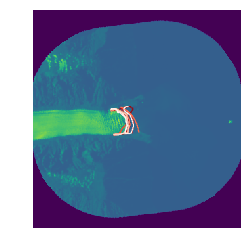

In [249]:
#imgplt = plt.imshow(images[40])
imgplt = plt.imshow(mpimg.imread('/home/jukes/Documents/Sample_glaciers/Box001/rotated_images/final/crop_PS_LC08_L1TP_031005_20180825_20180829_01_T1_B8_Buffer001cut.png'))
final_imgnames = []

xs = []
ys = []
for i in range(0, len(images)):
#     print(i)
    index = i
    #imgplt = plt.imshow(images[index])#cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))\
    avgpxval = np.average(images[index])
   
    #if the pixel value is above a threshold, then grab the terminus
    if avgpxval < 0.37:
        final_imgnames.append(imgnames[index])
        print(imgnames[index], "average pixel value:", avgpxval)
        term = term_dats[index]
        term_xs = []
        term_ys = []

        #grab x and y values for the terminus line
        for j in term:
            x, y = (j[0], j[1])
            term_xs.append(x)
            term_ys.append(y)
        
        xs.append(term_xs)
        ys.append(term_ys)

#create dataframe with the term line coordinates and sort by date
termlines_df = pd.DataFrame(
    {'imgnames': final_imgnames,
     'X': xs,
     'Y': ys
    })

termlines_df = termlines_df.sort_values(by=['imgnames'])
termlines_df.head()

# #create reversed red color map for the lines
n=len(termlines_df.index)
print("Lines:", n)
colors = pl.cm.Reds_r(np.linspace(0,1,n))
col_count = 0

name = list(termlines_df['imgnames'])
x_final = list(termlines_df['X'])
y_final = list(termlines_df['Y'])

#plot each termline
for a in range(0, n):
    x, y = x_final[a], y_final[a]
    pl.plot(x, y, color=colors[col_count], linewidth=1)
    col_count = col_count+1

plt.axis("off")
plt.savefig(basepath+"AGU2019_autolines_Box"+BOI+".png", dpi=300)

_Remnant code on plotting teminus changes:_

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()